# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: regression from muliple channels (spherical maps)

This notebook shows how to regress (multiple) parameters from (multiple) input channels (spherical maps).
It doesn't use real cosmological data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil

# Run on CPU.
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import healpy as hp
import tensorflow as tf

from deepsphere import models, experiment_helper, plot
from deepsphere.data import LabeledDataset
from deepsphere.utils import HiddenPrints

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

In [4]:
EXP_NAME = 'regression'

## 1 Data loading

Create a dataset by filtering random noise with different Gaussian filters.

In [5]:
Nside = 32
Nsamples = 1000

In [6]:
def arcmin2rad(x):
    return x / 60 / 360 * 2 * np.pi

def gaussian_smoothing(sig, sigma, nest=True):
    if nest:
        sig = hp.reorder(sig, n2r=True)
    smooth = hp.sphtfunc.smoothing(sig, sigma=sigma)
    if nest:
        smooth = hp.reorder(smooth, r2n=True)
    smooth /= np.linalg.norm(smooth)
    return smooth

In [7]:
x = np.random.randn(Nsamples, hp.nside2npix(Nside))
t = np.random.rand(Nsamples, 2) + 0.5

with HiddenPrints():
    xs1 = np.array(list(map(gaussian_smoothing, x, t[:, 0] / Nside)))    
    xs2 = np.array(list(map(gaussian_smoothing, x, t[:, 1] / Nside)))
xs = np.stack((xs1, xs2), axis=2)

Plot the spherical map before and after smoothing.

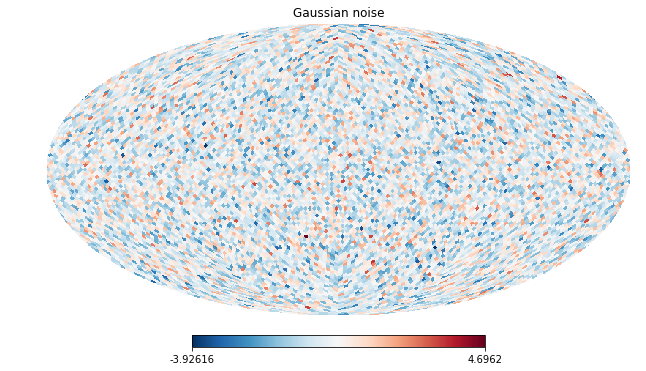

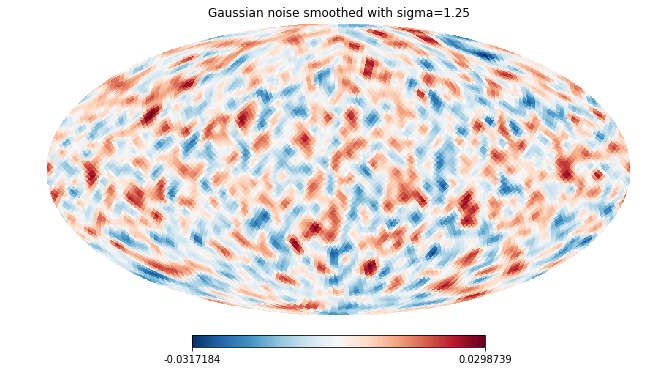

In [8]:
idx = 0
cm = plt.cm.RdBu_r
cm.set_under('w')
hp.mollview(x[idx], title='Gaussian noise', nest=True, cmap=cm)
hp.mollview(xs[idx, :, 0], title='Gaussian noise smoothed with sigma={:.2f}'.format(t[idx, 0]), nest=True, cmap=cm)

## 2 Data preparation

* The regression target is the stddev of the Gaussian filters.
* Split the data into training and test sets.

In [9]:
# Normalize and transform the data, i.e. extract features.
x_raw = xs / np.mean(xs**2) # Apply some normalization (We do not want to affect the mean)

# Create the label vector.
labels = t - 0.5

# Random train / test split.
ntrain = int(0.8 * Nsamples)
x_raw_train = x_raw[:ntrain]
x_raw_test = x_raw[ntrain:]
labels_train = labels[:ntrain]
labels_test = labels[ntrain:]

## 3 Regression using DeepSphere

In [10]:
params = dict()
params['dir_name'] = EXP_NAME

# Types of layers.
params['conv'] = 'chebyshev5'  # Graph convolution: chebyshev5 or monomials.
params['pool'] = 'max'  # Pooling: max or average.
params['activation'] = 'relu'  # Non-linearity: relu, elu, leaky_relu, softmax, tanh, etc.
params['statistics'] = None  # Statistics (for invariance): None, mean, var, meanvar, hist.

# Architecture.
params['statistics'] = 'mean'  # For predictions to be invariant to rotation.
params['nsides'] = [Nside, Nside//2, Nside//4, Nside//8]  # Pooling: number of pixels per layer.
params['F'] = [16, 32, 64]  # Graph convolutional layers: number of feature maps.
params['M'] = [64, 2]  # Fully connected layers: output dimensionalities. Predict two parameters.
params['input_channel'] = 2  # Two channels (spherical maps) per sample.
params['loss'] = 'l2'  # Regression loss.
params['K'] = [5] * len(params['F'])  # Polynomial orders.
params['batch_norm'] = [True] * len(params['F'])  # Batch normalization.

# Regularization.
params['regularization'] = 0  # Amount of L2 regularization over the weights (will be divided by the number of weights).
params['dropout'] = 1  # Percentage of neurons to keep.

# Training.
params['num_epochs'] = 10  # Number of passes through the training data.
params['batch_size'] = 16  # Number of samples per training batch. Should be a power of 2 for greater speed.
params['eval_frequency'] = 15  # Frequency of model evaluations during training (influence training time).
params['scheduler'] = lambda step: 1e-4  # Constant learning rate.
params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
#params['optimizer'] = lambda lr: tf.train.MomentumOptimizer(lr, momentum=0.5)
#params['optimizer'] = lambda lr: tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.99, epsilon=1e-8)

In [11]:
model = models.deepsphere(**params)

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 2 * 16 * 5 = 160
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  Statistical layer: mean
    representation: 1 * 64 = 64
  layer 4: fc1
    representation: M_4 = 64
    weights: M_3 * M_4 = 64 * 64 = 4096
    biases: M_4 = 64
  layer 5: fc2
    representation: M_5 = 2
    weights: M_4 * M_5 = 64 * 2 = 128


In [12]:
# Cleanup before running again.
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [13]:
training = LabeledDataset(x_raw_train, labels_train)
testing = LabeledDataset(x_raw_test, labels_test)

In [14]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, testing)

step 15 / 500 (epoch 0.30 / 10):
  learning_rate = 1.00e-04, training loss = 1.04e+00
  validation loss: 1.80e+00
  CPU time: 162s, wall time: 14s
step 30 / 500 (epoch 0.60 / 10):
  learning_rate = 1.00e-04, training loss = 5.58e-01
  validation loss: 1.43e+00
  CPU time: 324s, wall time: 26s
step 45 / 500 (epoch 0.90 / 10):
  learning_rate = 1.00e-04, training loss = 5.38e-01
  validation loss: 1.30e+00
  CPU time: 486s, wall time: 37s
step 60 / 500 (epoch 1.20 / 10):
  learning_rate = 1.00e-04, training loss = 6.24e-01
  validation loss: 1.26e+00
  CPU time: 647s, wall time: 48s
step 75 / 500 (epoch 1.50 / 10):
  learning_rate = 1.00e-04, training loss = 3.10e-01
  validation loss: 1.20e+00
  CPU time: 807s, wall time: 59s
step 90 / 500 (epoch 1.80 / 10):
  learning_rate = 1.00e-04, training loss = 3.11e-01
  validation loss: 1.16e+00
  CPU time: 970s, wall time: 70s
step 105 / 500 (epoch 2.10 / 10):
  learning_rate = 1.00e-04, training loss = 2.80e-01
  validation loss: 1.14e+00
  C

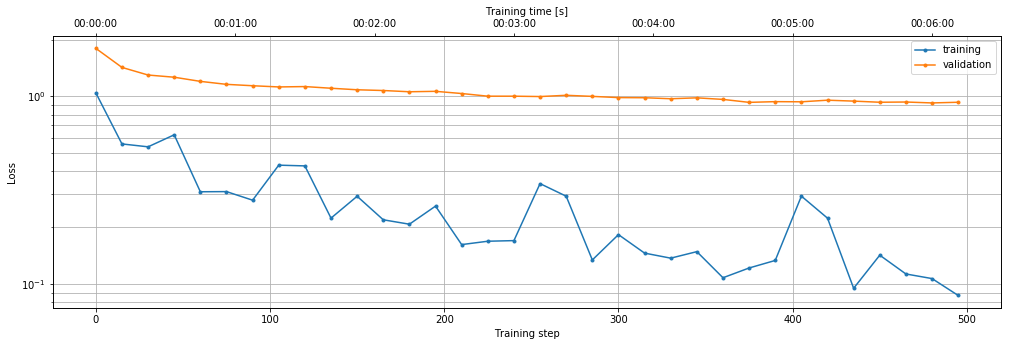

In [15]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

## 4 Prediction

In [16]:
pred_test = model.predict(x_raw_test)
pred_train = model.predict(x_raw_train)

/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/regression
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/regression/model-500
/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/regression
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/regression/model-500


In [17]:
np.mean(np.abs(pred_test - labels_test)) / np.std(labels_test)

0.1659902090010819

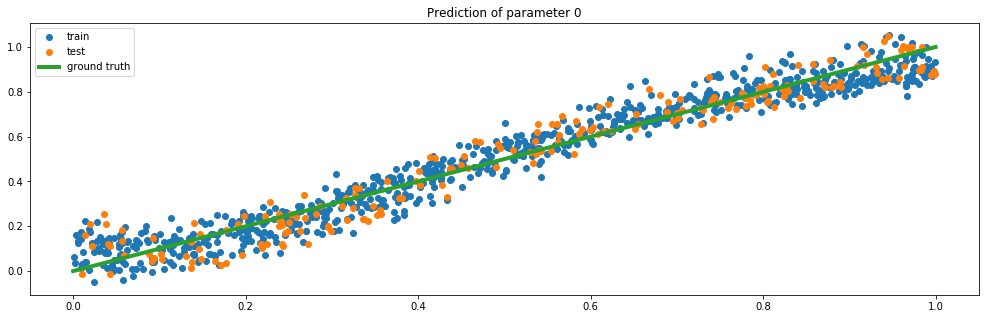

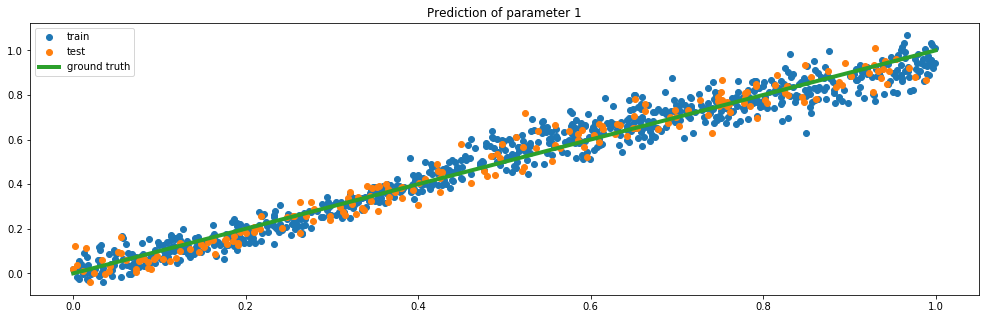

In [18]:
def plot_prediction(param=0):
    fig, ax = plt.subplots()
    ax.plot(labels_train[:, param], pred_train[:, param], 'o', label='train')
    ax.plot(labels_test[:, param], pred_test[:, param], 'o', label='test')
    ax.plot([0, 1], [0, 1], linewidth=4, label='ground truth')
    ax.set_title('Prediction of parameter {}'.format(param))
    ax.legend()

plot_prediction(0)
plot_prediction(1)